# Assessing Model Results

This notebook assesses some of the data outputted from An's model of the Tonkin Gulf. It then generates a visualization and comparisons between the model ran with and without wind and precipitation. A movie will be generated at the end of this notebook.

First, import packages to re-create and visualize the model fields here:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import moviepy.video.io.ImageSequenceClip
import cmocean.cm as cm

Next, define the location of the run directory for the model. This is the directory that holds all of the output from the model.

In [2]:
# define the input directory
run_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\run\\diags'
zero_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\run\\diags_zero'

Then, re-create the model grid

In [3]:
delX = 1/40
delY = 1/40
xgOrigin = 105.5
ygOrigin = 18.5
nrows = 140
ncols = 180

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+ncols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+nrows*delY, delY)
XC, YC = np.meshgrid(xc, yc)

## Plot a model field at one timestep
A good first assessment of a model is to plot some of the output fields. Here, I'll choose one of the surface temperature fields. I'll first read in the field, and then I'll plot it

In [4]:
grid = np.fromfile(os.path.join(run_dir,'TS_surf_daily_mean',
                                'TS_surf_daily_mean.0000002880.data'), '>f4')
grid = grid.reshape((2,nrows,ncols))

grid_zero = np.fromfile(os.path.join(zero_dir,'TS_surf_daily_mean',
                                'TS_surf_daily_mean.0000002880.data'), '>f4')
grid_zero = grid_zero.reshape((2,nrows,ncols))

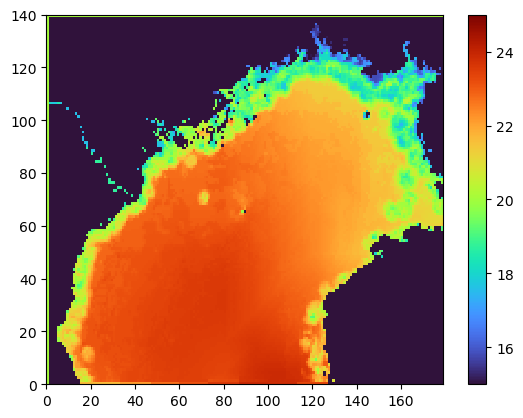

In [5]:
C = plt.pcolormesh(grid[0,:,:-1], cmap='turbo', vmin=15, vmax=25)
plt.colorbar(C)
plt.show()

## Make a timeseries
After plotting a few fields, next we can see how the model is evolving through time. For this example, I'll choose a point in the domain near the coast and I'll plot that on a map to ensure it's in the right location:

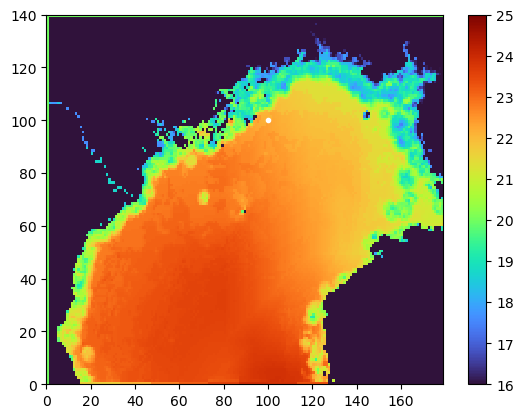

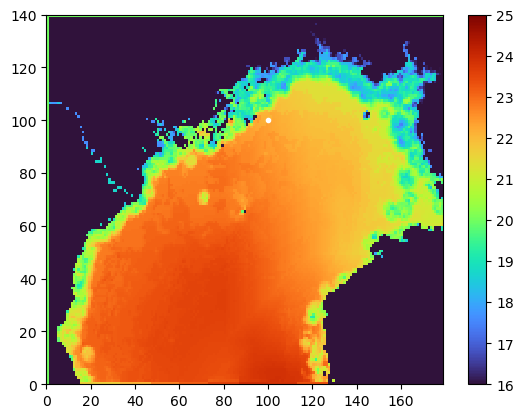

In [6]:
row = 100
col = 100
C = plt.pcolormesh(grid[0,:,:-1], cmap='turbo', vmin=16,vmax=25)
plt.plot(col,row,'w.')
plt.colorbar(C)
plt.show()

C = plt.pcolormesh(grid_zero[0,:,:-1], cmap='turbo', vmin=16,vmax=25)
plt.plot(col,row,'w.')
plt.colorbar(C)
plt.show()

When I'm happy with the location of the point, I'll loop through all of the output files to generate a timeseries:

In [7]:
timestep_numbers = []
theta_values = []
for file_name in sorted(os.listdir(os.path.join(run_dir,'TS_surf_daily_mean'))):
    if file_name[-4:]=='data':
        # get the timestep number
        timestep_numbers.append(int(file_name.split('.')[-2]))
        len(timestep_numbers)

        grid = np.fromfile(os.path.join(run_dir,'TS_surf_daily_mean',
                                file_name), '>f4')
        grid = grid.reshape((2,nrows,ncols))
        theta_values.append(grid[0,row,col])
        
timestep_numbers_zero = []
theta_zero_values = []
for file_name in sorted(os.listdir(os.path.join(zero_dir,'TS_surf_daily_mean'))):
    if file_name[-4:]=='data':
        # get the timestep number
        timestep_numbers_zero.append(int(file_name.split('.')[-2]))
        len(timestep_numbers)

        grid = np.fromfile(os.path.join(zero_dir,'TS_surf_daily_mean',
                                file_name), '>f4')
        grid = grid.reshape((2,nrows,ncols))
        theta_zero_values.append(grid[0,row,col])

Finally, I'll plot the timeseries:

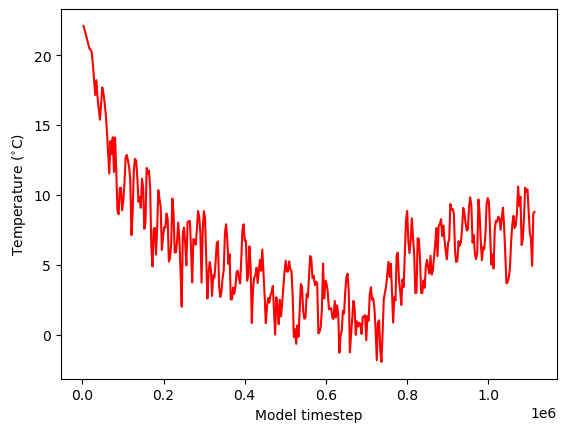

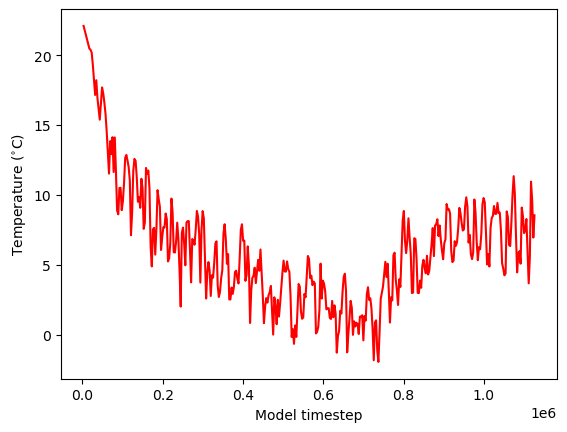

In [8]:
plt.plot(timestep_numbers, theta_values,'r-')
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('Model timestep')
plt.show()

plt.plot(timestep_numbers_zero, theta_zero_values,'r-')
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('Model timestep')
plt.show()

## Make a movie
The timeseries looks pretty good - let's take a look at how our model is evolving through time by making a movie. First, let's make and test a function to make the panels for our movie. It will be configured to be able to take any of our desired diagnostics and create a movie.

In [9]:
plot_dir = 'C:\\Users\\azure\\Documents\\CS185C\\project\\plots'

In [10]:
plot_dict = {
    'ETAN':    [-1.0,   1.0,   cm.balance, 'm'],
    'THETA':   [18.0,  25.0,   cm.thermal, '°C'],
    'SALT':    [32.0,  36.0,   cm.haline,  'PSU'],
    'MXLDEPTH':[ 0.0,  50.0,   cm.deep,    'm'],
    'UVEL':    [-2.0,   2.0,   cm.balance, 'm/s'],
    'VVEL':    [-2.0,   2.0,   cm.balance, 'm/s'],
}

# provide file names for diags
dir_meta = {
    'EtaN_day_snap':      {'var':'ETAN',      'num_slices':1, 'slice_idx':0},
    'EtaN_mon_mean':      {'var':'ETAN',      'num_slices':1, 'slice_idx':0},
    'vel_3D_mon_snap':    {'var':'VEL',       'num_slices':2, 'slice_idx':None},
    'TS_3D_mon_mean':     {'var':'TS',        'num_slices':2, 'slice_idx':None},
    'TS_surf_daily_mean': {'var':'TS',        'num_slices':2, 'slice_idx':None},
    'MXLDEPTH_day_snap':  {'var':'MXLDEPTH',  'num_slices':1, 'slice_idx':0},
    'MXLDEPTH_mon_mean':  {'var':'MXLDEPTH',  'num_slices':1, 'slice_idx':0},
}

In [11]:
def plot_panel(run_directory, plot_dir, file_name, zero_directory=None):
    subdir = os.path.basename(run_directory)               
    meta = dir_meta[subdir]
    nslice = meta['num_slices']
    var = meta['var']
    
    raw = np.fromfile(os.path.join(run_directory, file_name), dtype='>f4')
    ntot = raw.size
    base = nslice * nrows * ncols
    
    if ntot == base:
        grid = raw.reshape((nslice, nrows, ncols))
    else:
        nextra = ntot // base
        assert ntot % base == 0, f"Can't reshape array of size {ntot}"
        grid = raw.reshape((nslice, nextra, nrows, ncols))
        
    timestep_number = int(file_name.split('.')[-2])
    
    if zero_directory:
        raw_zero = np.fromfile(os.path.join(zero_directory,file_name), dtype='>f4')
        
        if ntot == base:
            grid_zero = raw_zero.reshape((nslice, nrows, ncols))
        else:
            nextra = ntot // base
            assert ntot % base == 0, f"Can't reshape array of size {ntot}"
            grid_zero = raw_zero.reshape((nslice, nextra, nrows, ncols))
        # Adjust figure size for side-by-side plots
        fig_width = 14 if zero_directory else 7
    else:
        fig_width = 7
    
    # Make a figure with appropriate size
    fig = plt.figure(figsize=(fig_width, 8))
    
    # Create different grid specs based on whether we're doing side-by-side comparison
    if zero_directory:
        gs_run = GridSpec(11, 10, left=0.05, right=0.48, bottom=0.06, top=0.95, hspace=0.05)
        gs_zero = GridSpec(11, 10, left=0.55, right=0.98, bottom=0.06, top=0.95, hspace=0.05)
    else:
        gs_run = GridSpec(11, 10, left=0.1, right=0.98, bottom=0.06, top=0.95, hspace=0.05)
    
    # Function to plot a single variable on an axis
    def plot_var(grid, gs, title_prefix=""):
        # Handle special cases for combined variables
        if grid.ndim == 4:
            lvl = meta.get('slice_idx', 0) or 0
            grid = grid[:, lvl, :, :]   # now shape is (nslice, nrows, ncols)
        
        if var == 'TS':
            # First slice is Temperature, second is Salinity
            # Plot Temperature
            ax1 = fig.add_subplot(gs[:4, :])
            vmin, vmax = plot_dict['THETA'][0], plot_dict['THETA'][1]
            cmap = plot_dict['THETA'][2]
            units = plot_dict['THETA'][3]
            C1 = ax1.pcolormesh(XC[:,:-1], YC[:,:-1], grid[0,:,:-1], cmap=cmap, vmin=vmin, vmax=vmax)
            plt.colorbar(C1, ax=ax1, label=f'Temperature ({units})')
            ax1.set_title(f'{title_prefix}Temperature')
            ax1.set_ylabel('Latitude')
            
            # Plot Salinity
            ax2 = fig.add_subplot(gs[5:9, :])
            vmin, vmax = plot_dict['SALT'][0], plot_dict['SALT'][1]
            cmap = plot_dict['SALT'][2]
            units = plot_dict['SALT'][3]
            C2 = ax2.pcolormesh(XC[:,:-1], YC[:,:-1], grid[1,:,:-1], cmap=cmap, vmin=vmin, vmax=vmax)
            plt.colorbar(C2, ax=ax2, label=f'Salinity ({units})')
            ax2.set_title(f'{title_prefix}Salinity')
            ax2.set_ylabel('Latitude')
            ax2.set_xlabel('Longitude')
            
            # Return axes for timelines
            return ax2
            
        elif var == 'VEL':
            # First slice is U velocity, second is V velocity
            # Plot U velocity
            ax1 = fig.add_subplot(gs[:4, :])
            vmin, vmax = plot_dict['UVEL'][0], plot_dict['UVEL'][1]
            cmap = plot_dict['UVEL'][2]
            units = plot_dict['UVEL'][3]
            C1 = ax1.pcolormesh(XC[:,:-1], YC[:,:-1], grid[0,:,:-1], cmap=cmap, vmin=vmin, vmax=vmax)
            plt.colorbar(C1, ax=ax1, label=f'U Velocity ({units})')
            ax1.set_title(f'{title_prefix}U Velocity')
            ax1.set_ylabel('Latitude')
            
            # Plot V velocity
            ax2 = fig.add_subplot(gs[5:9, :])
            vmin, vmax = plot_dict['VVEL'][0], plot_dict['VVEL'][1]
            cmap = plot_dict['VVEL'][2]
            units = plot_dict['VVEL'][3]
            C2 = ax2.pcolormesh(XC[:,:-1], YC[:,:-1], grid[1,:,:-1], cmap=cmap, vmin=vmin, vmax=vmax)
            plt.colorbar(C2, ax=ax2, label=f'V Velocity ({units})')
            ax2.set_title(f'{title_prefix}V Velocity')
            ax2.set_ylabel('Latitude')
            ax2.set_xlabel('Longitude')
            
            # Return axes for timelines
            return ax2
            
        else:
            # Handle single variable plots
            ax = fig.add_subplot(gs[:-2, :])
            
            # Use the slice_idx if specified, otherwise use the first slice
            slice_idx = meta['slice_idx'] if meta['slice_idx'] is not None else 0
            
            # Get plot parameters from plot_dict
            vmin, vmax = plot_dict[var][0], plot_dict[var][1]
            cmap = plot_dict[var][2]
            units = plot_dict[var][3]
            
            C = ax.pcolormesh(XC[:,:-1], YC[:,:-1], grid[slice_idx,:,:-1], cmap=cmap, vmin=vmin, vmax=vmax)
            plt.colorbar(C, ax=ax, label=f'{var} ({units})')
            
            # Format the axes
            ax.set_title(f'{title_prefix}{var} - {subdir}')
            ax.set_ylabel('Latitude')
            ax.set_xlabel('Longitude')
            
            # Return axes for timelines
            return ax
    
    # Plot run data
    last_ax_run = plot_var(grid, gs_run, title_prefix="Control: " if zero_directory else "")
    
    # Plot zero data if provided
    if zero_directory:
        last_ax_zero = plot_var(grid_zero, gs_zero, title_prefix="Modified: ")
    
    # Time axis at the bottom
    max_timestep_number = int(366*24*60*60/30)

    
    if zero_directory:
        # Add time axis for run data
        time_ax_run = fig.add_subplot(gs_run[-1, :-2])
        rect_run = Rectangle((0,0), timestep_number, 1, facecolor='grey', edgecolor='k')
        time_ax_run.add_patch(rect_run)
        time_ax_run.set_xlim([0, max_timestep_number])
        time_ax_run.set_ylim([0, 1])
        time_ax_run.set_xticks([0, max_timestep_number])
        time_ax_run.set_xticklabels([2004, 2005])
        time_ax_run.set_yticklabels([])
        time_ax_run.set_xlabel('Time')
        
        # Add time axis for zero data
        time_ax_zero = fig.add_subplot(gs_zero[-1, :-2])
        rect_zero = Rectangle((0,0), timestep_number, 1, facecolor='grey', edgecolor='k')
        time_ax_zero.add_patch(rect_zero)
        time_ax_zero.set_xlim([0, max_timestep_number])
        time_ax_zero.set_ylim([0, 1])
        time_ax_zero.set_xticks([0, max_timestep_number])
        time_ax_zero.set_xticklabels([2004, 2005])
        time_ax_zero.set_yticklabels([])
        time_ax_zero.set_xlabel('Time')
    else:
        # Add time axis for single plot
        time_ax = fig.add_subplot(gs_run[-1, :-2])
        rect = Rectangle((0,0), timestep_number, 1, facecolor='grey', edgecolor='k')
        time_ax.add_patch(rect)
        time_ax.set_xlim([0, max_timestep_number])
        time_ax.set_ylim([0, 1])
        time_ax.set_xticks([0, max_timestep_number])
        time_ax.set_xticklabels([2004, 2005])
        time_ax.set_yticklabels([])
        time_ax.set_xlabel('Time')
    
    # Create variable-specific output directory
    # First make sure the panels directory exists
    if not os.path.exists(os.path.join(plot_dir, 'panels')):
        os.mkdir(os.path.join(plot_dir, 'panels'))
    
    # Then create a subdirectory for the specific variable
    var_dir = os.path.join(plot_dir, 'panels', var)
    if not os.path.exists(var_dir):
        os.mkdir(var_dir)
    
    # Further create a subdirectory for the diagnostic type
    diag_dir = os.path.join(var_dir, subdir)
    if not os.path.exists(diag_dir):
        os.mkdir(diag_dir)
    
    # Save the figure with appropriate naming
    output_name = f"{file_name[:-5]}_{'comparison' if zero_directory else 'single'}.png"
    output_file = os.path.join(diag_dir, output_name)
    plt.savefig(output_file, facecolor='white')
    plt.close(fig)

When we're happy with the plotting function, we can use it to make the panels. Below is a method to iterate over all data files.

In [12]:
def plot_all(run_dir, plot_dir, zero_dir=None):
    for sub in sorted(os.listdir(run_dir)):
        run_subpath = os.path.join(run_dir, sub)
        print(run_subpath)
        if not os.path.isdir(run_subpath):
            continue
            
        # Check if the corresponding directory exists in zero_dir
        zero_subpath = None
        if zero_dir and os.path.exists(os.path.join(zero_dir, sub)):
            zero_subpath = os.path.join(zero_dir, sub)
            
        for fname in sorted(os.listdir(run_subpath)):
            if not fname.endswith('.data'):
                continue
                
            # Make sure the file exists in both directories if we're doing a comparison
            if zero_subpath and not os.path.exists(os.path.join(zero_subpath, fname)):
                print(f"Warning: File {fname} not found in zero directory. Skipping comparison.")
                plot_panel(run_subpath, plot_dir, fname)  # Plot run_dir only
            else:
                # Call plot_panel with appropriate arguments
                plot_panel(run_subpath, plot_dir, fname, zero_subpath)

And then stitch everything together into a movie:

In [13]:
def create_movies(plot_dir, fps=5):

    # Check if panels directory exists
    panels_dir = os.path.join(plot_dir, 'panels')
    if not os.path.exists(panels_dir):
        print(f"Error: Panels directory {panels_dir} not found.")
        return
    
    # Scan through the variable directories
    for var_name in sorted(os.listdir(panels_dir)):
        var_path = os.path.join(panels_dir, var_name)
        if not os.path.isdir(var_path):
            continue
            
        print(f"Processing variable: {var_name}")
        
        # Scan through diagnostic directories for this variable
        for diag_name in sorted(os.listdir(var_path)):
            diag_path = os.path.join(var_path, diag_name)
            if not os.path.isdir(diag_path):
                continue
                
            print(f"  Processing diagnostic: {diag_name}")
            
            # Sort the image files to ensure proper sequence
            # Separate single and comparison plots
            single_panels = []
            comparison_panels = []
            
            for file_name in sorted(os.listdir(diag_path)):
                if not file_name.endswith('.png'):
                    continue
                    
                full_path = os.path.join(diag_path, file_name)
                
                if 'comparison' in file_name:
                    comparison_panels.append(full_path)
                else:
                    single_panels.append(full_path)
            
            # Create movies if we have enough frames
            if len(single_panels) > 0:
                create_movie(single_panels, plot_dir, var_name, diag_name, "single", fps)
                
            if len(comparison_panels) > 0:
                create_movie(comparison_panels, plot_dir, var_name, diag_name, "comparison", fps)

def create_movie(panel_list, plot_dir, var_name, diag_name, plot_type, fps):
 
    if len(panel_list) < 2:
        print(f"    Not enough frames for {var_name}/{diag_name}/{plot_type} (found {len(panel_list)})")
        return
        
    # Create descriptive movie titles based on variable and diagnostic types
    variable_descriptive_names = {
        'ETAN': 'Sea Surface Height',
        'THETA': 'Temperature',
        'SALT': 'Salinity',
        'MXLDEPTH': 'Mixed Layer Depth',
        'VEL': 'Current Velocity'
    }
    
    diagnostic_descriptive_names = {
        'EtaN_day_snap': 'Daily Snapshot',
        'EtaN_mon_mean': 'Monthly Mean',
        'vel_3D_mon_snap': 'Monthly Snapshot',
        'TS_3D_mon_mean': '3D Monthly Mean',
        'TS_surf_daily_mean': 'Surface Daily Mean',
        'MXLDEPTH_day_snap': 'Daily Snapshot',
        'MXLDEPTH_mon_mean': 'Monthly Mean'
    }
    
    # Get descriptive names or use the original if not found
    var_desc = variable_descriptive_names.get(var_name, var_name)
    diag_desc = diagnostic_descriptive_names.get(diag_name, diag_name)
    
    # Construct a human-readable movie title
    if plot_type == 'comparison':
        title = f"Tonkin Gulf {var_desc} {diag_desc} - Control vs Modified"
    else:
        title = f"Tonkin Gulf {var_desc} {diag_desc}"
    
    # Create a file name based on the variables
    movie_name = f"{var_name}_{diag_name}_{plot_type}.mp4"
    
    # Create movies directory if it doesn't exist
    movies_dir = os.path.join(plot_dir, 'movies','Side-by-Side Comparison Movies')
    # os.mkdir(movies_dir)
    
    # Full path for the movie
    movie_path = os.path.join(movies_dir, movie_name)
    
    print(f"    Creating movie: {title} with {len(panel_list)} frames")
    
    # Create the movie
    try:
        clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(panel_list, fps=fps)
        clip.write_videofile(movie_path, verbose=False, logger=None)
        print(f"    Successfully created: {movie_path}")
    except Exception as e:
        print(f"    Error creating movie {title}: {str(e)}")

Run the methods to generate the movies.

In [14]:
# plot_all(run_dir, plot_dir, zero_dir)
create_movies(plot_dir, 5)

Processing variable: ETAN
  Processing diagnostic: EtaN_day_snap
    Creating movie: Tonkin Gulf Sea Surface Height Daily Snapshot - Control vs Modified with 388 frames
    Successfully created: C:\Users\azure\Documents\CS185C\project\plots\movies\Side-by-Side Comparison Movies\ETAN_EtaN_day_snap_comparison.mp4
  Processing diagnostic: EtaN_mon_mean
    Creating movie: Tonkin Gulf Sea Surface Height Monthly Mean - Control vs Modified with 13 frames
    Successfully created: C:\Users\azure\Documents\CS185C\project\plots\movies\Side-by-Side Comparison Movies\ETAN_EtaN_mon_mean_comparison.mp4
Processing variable: MXLDEPTH
  Processing diagnostic: MXLDEPTH_day_snap
    Creating movie: Tonkin Gulf Mixed Layer Depth Daily Snapshot - Control vs Modified with 386 frames
    Successfully created: C:\Users\azure\Documents\CS185C\project\plots\movies\Side-by-Side Comparison Movies\MXLDEPTH_MXLDEPTH_day_snap_comparison.mp4
  Processing diagnostic: MXLDEPTH_mon_mean
    Creating movie: Tonkin Gulf 

This is to provide some visualization into the data and how each model data set looks. Next, I will look to answer the science question posed in the README by analyzing the data further.